# Comparing Pangenome pipeline predictions - Shaw2021 - 50 e. coli genomes

### Import Statements

In [115]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [116]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [162]:
%reload_ext autoreload
%autoreload 2
    
from panqc.utils import get_PG_Stats_FromPresAbs
from panqc.utils import get_PG_Stats_FromPresAbs_V2


# Define Functions

In [119]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [120]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [121]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [122]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

In [123]:

def calculate_gene_gain_loss_stats(branchstats_tsv):
    """
    Calculate gene gain and loss statistics for ancestral branches and tips
    from a branchstats.tsv file generated by Panstripe software.
    
    Parameters:
        branchstats_tsv (str): Path to the branchstats.tsv file.
        
    Returns:
        dict: A dictionary containing the four statistics:
              - N_Gain_AncBranches: Total number of genes gained on ancestral branches.
              - N_Loss_AncBranches: Total number of genes lost on ancestral branches.
              - N_Gain_Tips: Total number of genes gained on tips.
              - N_Loss_Tips: Total number of genes lost on tips.
    """
    # Load the data
    data = pd.read_csv(branchstats_tsv, sep="\t")
    
    # Split the data into ancestral branches and tips
    data_tips = data.query("istip == 1")
    data_ancs = data.query("istip == 0")
    
    # Calculate statistics
    stats = {
        "N_Gain_Ancs": data_ancs["acc_gain"].sum(),
        "N_Loss_Ancs": data_ancs["acc_loss"].sum(),
        "N_Gain_Tips": data_tips["acc_gain"].sum(),
        "N_Loss_Tips": data_tips["acc_loss"].sum()
    }
    
    return stats

# Example usage:
# file_path = "path/to/Panstripe.BranchStats.tsv"
# stats = calculate_gene_gain_loss_stats(file_path)
# print(stats)


# Define paths to sample metadata files & key directories

In [124]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

SA_PG_MainDir = f"{Proj_MainDir}/241206_Saureus_PG_Analysis"  

Data_MainDir = f"{SA_PG_MainDir}/Data"  

SA_68CI_GenomeFASTAs_Dir = f"{Data_MainDir}/CRS.Saureus.68CI.GenomesFromGitRepo"

HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV = f"{SA_PG_MainDir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"


Saureus_Repo_Meta_Dir = f"../../Data/241206_Saureus_HoutakBouras2023_Metadata"  

Sa_ENA_RunData_TSV = f"{Saureus_Repo_Meta_Dir}/ENA.RunMetadata.PRJNA914892.tsv"

Sa_HoutakBouras2023_Isolate_Metadata_TSV = f"{Saureus_Repo_Meta_Dir}/HoutakBouras2023.metadata.csv"

Sa_HoutakBouras2023_Isolate_MLST_Info_TSV = f"{Saureus_Repo_Meta_Dir}/metadata/poppunk_mlst.csv"



Sa_HoutakBouras2023_NCBI_GenomeInfo_TSV  = f"{Saureus_Repo_Meta_Dir}/NCBI.HoutakBouras2023.Saureus.174CI.HybridGenomes.tsv"

HoutakBouras2023_Saureus_68CI_AsmPATH_TSV = f"{Saureus_Repo_Meta_Dir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"



## Parse in metadata DFs

In [125]:
SA_68CI_Info_DF = pd.read_csv(HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV,
                               sep = "\t")
print(SA_68CI_Info_DF.shape)

#Sa_68CI_Info_DF = pd.merge(Sa_68CI_Info_DF, MLST_DF, how = "left",
#                           left_on="SampleID", right_on = "SampleID" )

print(SA_68CI_Info_DF.shape)

(68, 8)
(68, 8)


### Define list of SampleIDs

In [126]:
SA_68CI_Info_DF.head(1)  

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [127]:
SA68I_SampleIDs = SA_68CI_Info_DF["SampleID"].values   
len(SA68I_SampleIDs)

68

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [128]:
# Define genome analysis and pan-genome pipeline output directories

WGA_SMK_Outputs_Dir = f"{SA_PG_MainDir}/SMK_OutDirs"

#PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"
PG_SA_68I_OutDir = WGA_SMK_Outputs_Dir + "/241206_Saureus_HoutakBouras2023_68I_V1"


In [129]:
#!ls -alh $PG_Ecoli_50I_OutDir

# Define output files & parse results for each pipeline

In [130]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs' ] 

# PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
#                          'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict','Panaroo_Moderate', 'Panaroo_Sensitive',
#                          'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
#                          'Roary_NoSplitParalogs',  'Roary_Default', 'Ppanggolin_Default',]


target_OutputDir = PG_SA_68I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
        #for AsmTech in ["LongRead"]:       

            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                
                if (AsmTech == "ShortRead") & (AnnoPipeline == "PGAP"): continue 
                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/"+SeqTechPrefix+i_PipeNameWiParam+DataSetSuffix+AnnoSuffix

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/Pangene/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"


                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    if "MergeParalogs" in i_PipeNameWiParam:
                        i_panqc_outdir = f"{i_Pipeline_OutDir}/panqc_NRC_OutDir/"
                        
                        i_PanQC_AsmSeqCheck_TSV = f"{i_panqc_outdir}/Step1_AsmSeqCheck/AsmSeqCheck.Stats.tsv"
                        i_panqc_AsmSeqCheck_DF = pd.read_csv(i_PanQC_AsmSeqCheck_TSV, sep ="\t")

                        i_PG_Stats_DF["N_CDS_Absent_Total"] = i_panqc_AsmSeqCheck_DF["N_Absent_Total"].values[0]
                        i_PG_Stats_DF["N_CDS_Present"] = i_panqc_AsmSeqCheck_DF["N_Present"].values[0]
                        i_PG_Stats_DF["N_CDSAbsent_DNAAbsent"] = i_panqc_AsmSeqCheck_DF["N_Absent_AbsentInDNA"].values[0]
                        i_PG_Stats_DF["N_CDSAbsent_DNAPresent"] = i_panqc_AsmSeqCheck_DF["N_Absent_PresentInDNA"].values[0]     
                        
                        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["panqc_AsmSeqCheck_DF"] = i_panqc_AsmSeqCheck_DF

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"

                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                
                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]

                    if "NoSplitParalogs" in i_PipeNameWiParam:
                        i_panqc_outdir = f"{i_Pipeline_OutDir}/panqc_NRC_OutDir/"
                        
                        i_PanQC_AsmSeqCheck_TSV = f"{i_panqc_outdir}/Step1_AsmSeqCheck/AsmSeqCheck.Stats.tsv"
                        i_panqc_AsmSeqCheck_DF = pd.read_csv(i_PanQC_AsmSeqCheck_TSV, sep ="\t")

                        i_PG_Stats_DF["N_CDS_Absent_Total"] = i_panqc_AsmSeqCheck_DF["N_Absent_Total"].values[0]
                        i_PG_Stats_DF["N_CDS_Present"] = i_panqc_AsmSeqCheck_DF["N_Present"].values[0]
                        i_PG_Stats_DF["N_CDSAbsent_DNAAbsent"] = i_panqc_AsmSeqCheck_DF["N_Absent_AbsentInDNA"].values[0]
                        i_PG_Stats_DF["N_CDSAbsent_DNAPresent"] = i_panqc_AsmSeqCheck_DF["N_Absent_PresentInDNA"].values[0]
                        
                        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["panqc_AsmSeqCheck_DF"] = i_panqc_AsmSeqCheck_DF

                        
                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt

100%|██████████| 6/6 [00:00<00:00, 79.94it/s]


In [131]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,105466,173334,103061,2405


In [132]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"] 

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4100,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405
0,Core genes,(99% <= strains <= 100%),2144,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405
5,Accessory genes,(0% <= strains < 99%),1956,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405


In [133]:
#!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/


In [134]:
#!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/SR_Pangene_0.9.Miniprot0.95_AllIsolates

In [135]:
#dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Panaroo_Strict_MergeParalogs"]


In [136]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4100,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405
0,Core genes,(99% <= strains <= 100%),2144,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405
5,Accessory genes,(0% <= strains < 99%),1956,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,105466,173334,103061,2405


In [137]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]["Method"].unique()

array(['Panaroo_Strict_MergeParalogs'], dtype=object)

In [139]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs_I80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4009,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566
0,Core genes,(99% <= strains <= 100%),2134,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566
5,Accessory genes,(0% <= strains < 99%),1875,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566


In [140]:
dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Roary_NoSplitParalogs_I80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4023,Bakta,Roary_NoSplitParalogs_I80,ShortRead,All,103772,169792,103285,487
5,Accessory genes,(0% <= strains < 99%),2281,Bakta,Roary_NoSplitParalogs_I80,ShortRead,All,103772,169792,103285,487
0,Core genes,(99% <= strains <= 100%),1742,Bakta,Roary_NoSplitParalogs_I80,ShortRead,All,103772,169792,103285,487


In [141]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),5032,Bakta,Roary_NoSplitParalogs,LongRead,All,168980,173196,162380,6600
5,Accessory genes,(0% <= strains < 99%),3024,Bakta,Roary_NoSplitParalogs,LongRead,All,168980,173196,162380,6600
0,Core genes,(99% <= strains <= 100%),2008,Bakta,Roary_NoSplitParalogs,LongRead,All,168980,173196,162380,6600


In [142]:
dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Roary_NoSplitParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4996,Bakta,Roary_NoSplitParalogs,ShortRead,All,167868,171860,161694,6174
5,Accessory genes,(0% <= strains < 99%),3347,Bakta,Roary_NoSplitParalogs,ShortRead,All,167868,171860,161694,6174
0,Core genes,(99% <= strains <= 100%),1649,Bakta,Roary_NoSplitParalogs,ShortRead,All,167868,171860,161694,6174


In [143]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Sensitive_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4245,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,114480,174180,111852,2628
0,Core genes,(99% <= strains <= 100%),2145,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,114480,174180,111852,2628
5,Accessory genes,(0% <= strains < 99%),2100,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,114480,174180,111852,2628


In [144]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs_I80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent
4,Total genes,(0% <= strains <= 100%),4009,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566
0,Core genes,(99% <= strains <= 100%),2134,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566
5,Accessory genes,(0% <= strains < 99%),1875,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,101654,170958,101088,566


In [146]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,105466,173334,103061,2405


In [147]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Panaroo_Sensitive_MergeParalogs"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,114480,174180,111852,2628


In [148]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs_I90"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,123845,172499,122982,863


In [150]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs_I90"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,123845,172499,122982,863


In [151]:
dictOf_PG_OutDir_PATHs["All"]["Bakta"]["LongRead"]["Roary_NoSplitParalogs_I80"]["panqc_AsmSeqCheck_DF"]

,N_Absent_Total,N_Present,N_Absent_AbsentInDNA,N_Absent_PresentInDNA
0,101654,170958,101088,566


In [153]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Pangene/Pangene_0.9.Miniprot0.95_AllIsolates/


Pangene_0.9.Miniprot0.95.gene_presence_absence.Rtab
Pangene_0.9.Miniprot0.95.gfa


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [154]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs' ] 


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]: 
    for AnnoPipeline in ["Bakta"]:
        #for AsmTech in ["LongRead"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_LRandSR_DF.shape


(36, 15)

In [155]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]["Method"].unique()

array(['Panaroo_Strict_MergeParalogs'], dtype=object)

In [158]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Panaroo    18
Roary      18
Name: PangenomeTool, dtype: int64

In [159]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].nunique()

2

In [161]:
PG_Merged_Stats_LRandSR_DF["Method"].nunique()

6

In [ ]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

In [ ]:
PG_Merged_Stats_LRandSR_DF.shape

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [ ]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [ ]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [ ]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [ ]:
# PG_Merged_Stats_LR_DF = pd.concat([Panaroo_Strict_Stats_DF,
#                                 Panaroo_Moderate_Stats_DF,
#                                 Panaroo_Sensitive_Stats_DF,
#                                 Roary_Default_Stats_DF,
#                                 Roary_NoSplit_Stats_DF,
#                                 Roary_NoSplitI90_Stats_DF,
#                                 Ppanggolin_Default_Stats_DF])

# PG_Merged_Stats_LR_DF.shape

### Explore data structure a bit

In [ ]:
PG_Merged_Stats_LRandSR_DF.head(4)

In [ ]:
PG_Merged_Stats_LRandSR_DF["Category"].value_counts()

### Output `PG_Merged_Stats_LRandSR_DF` to TSV

In [ ]:
#PG_Results_OutDir = "../../Data/240116.PG_Results" 

#!mkdir $PG_Results_OutDir

#PG_Merged_Stats_LRandSR_DF.to_csv(f"{PG_Results_OutDir}/Ecoli50CI.PG_Merged_Stats_LRandSR.tsv", sep="\t", index=False)


In [ ]:
PG_Merged_Stats_LRandSR_DF.head(4)

## Create mapping of tool-parameter ID to name

In [ ]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',]


PGCombos_TickLabels = [
    'Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
    'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
    'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)',
    'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
    'Roary \n (MergeParalogs)', 'Roary \n (Default)',
    'Ppanggolin (I0.80-C0.60)', 'Ppanggolin (I0.80-C0.80)',
    'Ppanggolin (I0.80-C0.90)', 'Ppanggolin (I0.90-C0.60)',
    'Ppanggolin (I0.90-C0.80)', 'Ppanggolin (I0.90-C0.90)',
    'Ppanggolin (I0.98-C0.60)', 'Ppanggolin (I0.98-C0.80)',
    'Ppanggolin (I0.98-C0.90)', 'Pangene \n (C0.9-M0.95)',
    'Pangene \n (C0.9-M0.98)', 'Pangene \n (C0.9-M0.99)',
    'Pangene \n (C0.9-M0.9)', 'Pangene \n (C0.95-M0.95)',
    'Pangene \n (C0.95-M0.98)', 'Pangene \n (C0.95-M0.99)',
    'Pangene \n (C0.95-M0.9)', 'Pangene \n (C0.98-M0.95)',
    'Pangene \n (C0.98-M0.98)', 'Pangene \n (C0.98-M0.99)',
    'Pangene \n (C0.98-M0.9)'
]


PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PipeName_WiParam_List)):
        
    PGCombos_dictOfValues_To_Label[PipeName_WiParam_List[i]]   =   PGCombos_TickLabels[i]
    
PGCombos_dictOfValues_To_Label

# 2) Create Pan-genome summary table - Wide version 

This table will have pangenome predictions (Total, Core, and Accessory genes) across all methods + technologies.

### Pivot table to get summary per Method and Seqtype

In [ ]:
PG_Merged_Stats_LRandSR_DF.head(2)

In [ ]:
df = PG_Merged_Stats_LRandSR_DF
# Reshape the DataFrame
# Pivot the data to have separate columns for Total_Genes, Core_Genes, and Accessory_Genes
reshaped_df = df.pivot_table(
    index=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'], 
    columns='Category', 
    values='GeneCount'
).reset_index()

# Merge the reshaped data with the original DataFrame to include other statistics
stats_columns = ['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', ]
                 #'N_Gain_Ancs', 'N_Loss_Ancs', 'N_Gain_Tips', 'N_Loss_Tips']
stats_df = df[stats_columns].drop_duplicates()

# Merge reshaped data with stats
final_df = reshaped_df.merge(stats_df, on=['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool'])

final_df = final_df.sort_values("Method",
                                key=lambda x: pd.Categorical(x, categories=PipeName_WiParam_List, ordered=True))

final_df["Method_V2"] = final_df["Method"].replace(PGCombos_dictOfValues_To_Label)

#final_df["N_Events_Ancs"] = final_df["N_Gain_Ancs"] + final_df["N_Loss_Ancs"]
#final_df["N_Events_Tips"] = final_df["N_Gain_Tips"] + final_df["N_Loss_Tips"]

PG_WideSumm_V2_DF = final_df
PG_WideSumm_DF = PG_WideSumm_V2_DF

In [ ]:
PG_WideSumm_DF.columns

In [ ]:
PG_WideSumm_DF.query("SeqType == 'LongRead'")   

In [ ]:
PG_WideSumm_DF.query("SeqType == 'ShortRead'")    

In [ ]:
PG_WideSumm_DF

# Plotting key figures (For SR vs LR - Bakta + 3 pipelines)

# Table 1) Pan-genome predictions - LR vs SR - 3 pipelines

In [ ]:
PG_WideSumm_DF.head(1)

In [ ]:
#print(PG_WideSumm_DF.to_latex())

In [18]:
PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"])

NameError: name 'PG_WideSumm_DF' is not defined

In [ ]:
PG_WideSumm_DF

In [53]:
PG_WideSumm_DF["Weight"] = PG_WideSumm_DF.groupby("Method")["Accessory genes"].transform('sum') / 2

In [54]:
#PG_WideSumm_DF

In [55]:
PG_WideSumm_V2_DF.shape

(62, 9)

In [56]:
PG_WideSumm_V2_DF.to_csv("PG_Merged_Stats_LRandSR_DF.pivot.V2.csv", index=False)

In [57]:

NewColOrder = ['PangenomeTool', 'SeqType', 'Annotation', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [58]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Annotation", "PangenomeTool"]).median()

Accessory genes  Core genes  Total genes
SeqType   Annotation PangenomeTool                                          
LongRead  Bakta      Panaroo                 2183.0      2144.0       4327.0
                     Pangene                 1802.0      2261.0       4064.5
                     Ppanggolin              2553.0      2189.0       4742.0
                     Roary                   2645.0      2050.0       4695.0
ShortRead Bakta      Panaroo                 2109.5      1780.0       3890.0
                     Pangene                 1781.0      2230.5       4007.5
                     Ppanggolin              2566.0      2186.0       4752.0
                     Roary                   2992.5      1682.0       4674.5

In [59]:
PG_WideSumm_V2_DF.columns

Index(['Method', 'SeqType', 'DataSet', 'Annotation', 'PangenomeTool', 'Accessory genes', 'Core genes', 'Total genes', 'Method_V2'], dtype='object')

In [60]:
PG_WideSumm_DF.groupby("SeqType")["Total genes"].describe()

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,31.0,4661.677419,1084.939089,3999.0,4077.5,4204.0,4602.5,7767.0
ShortRead,31.0,4557.322581,1088.556610,3791.0,3992.0,4039.0,4557.0,7689.0


In [61]:
PG_WideSumm_DF.head(4)

,Method,SeqType,DataSet,Annotation,PangenomeTool,Accessory genes,Core genes,Total genes,Method_V2,Weight
0,Panaroo_Moderate,LongRead,All,Bakta,Panaroo,2301,2144,4445,Panaroo \n (Moderate),2213.0
1,Panaroo_Moderate,ShortRead,All,Bakta,Panaroo,2125,1780,3905,Panaroo \n (Moderate),2213.0
2,Panaroo_Moderate_MergeParalogs,LongRead,All,Bakta,Panaroo,1990,2145,4135,Panaroo \n (Moderate & MergeParalogs),2042.0
3,Panaroo_Moderate_MergeParalogs,ShortRead,All,Bakta,Panaroo,2094,1781,3875,Panaroo \n (Moderate & MergeParalogs),2042.0


In [62]:
#PG_WideSumm_DF.to_csv("PG.LRvsSR.BaktaAnno.tsv", sep="\t", index= False)  

In [63]:
#PG_Merged_Stats_LRandSR_DF.to_csv("PG.LRvsSR.BaktaAnno.MergedStats.tsv", sep="\t", index= False)  

In [64]:
#PG_Merged_Stats_LRandSR_DF.columns   

In [65]:
PG_Merged_Stats_LRandSR_DF.head(2)  

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),4100,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),2144,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [66]:
import matplotlib.patches as mpatches


In [67]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].value_counts()  

Pangene       24
Ppanggolin    18
Panaroo       12
Roary          8
Name: PangenomeTool, dtype: int64

In [68]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]


## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [69]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [70]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [71]:
PG_Merged_Stats_LRandSR_Acc_DF.head(5)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
5,Accessory genes,(0% <= strains < 99%),1956,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),1990,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),2100,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),2266,Bakta,Panaroo_Strict,LongRead,All,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),2301,Bakta,Panaroo_Moderate,LongRead,All,Panaroo_Moderate_LongRead,Panaroo_Moderate_LongRead_Bakta,Bakta-LongRead,Panaroo


# Viz Explore - V2

In [72]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [73]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


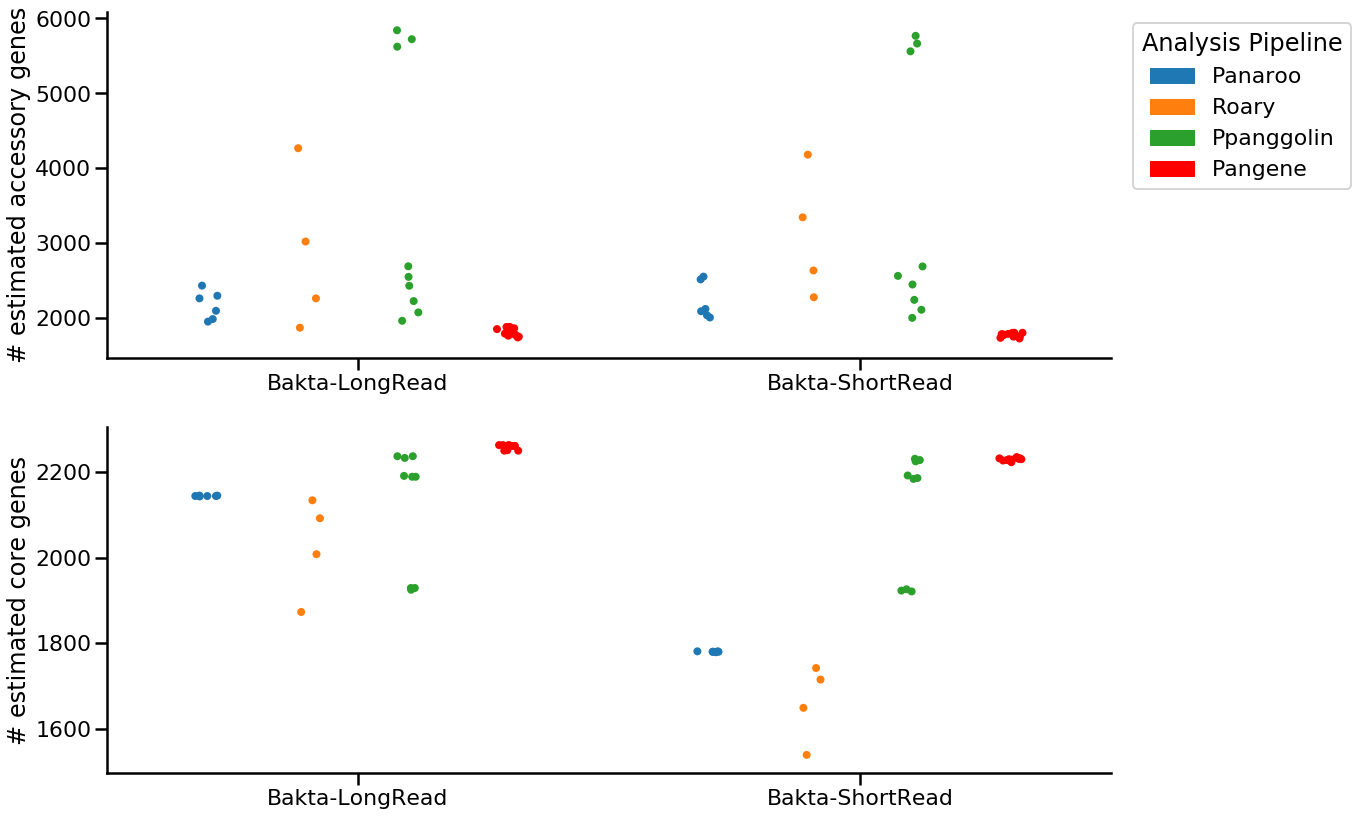

In [74]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

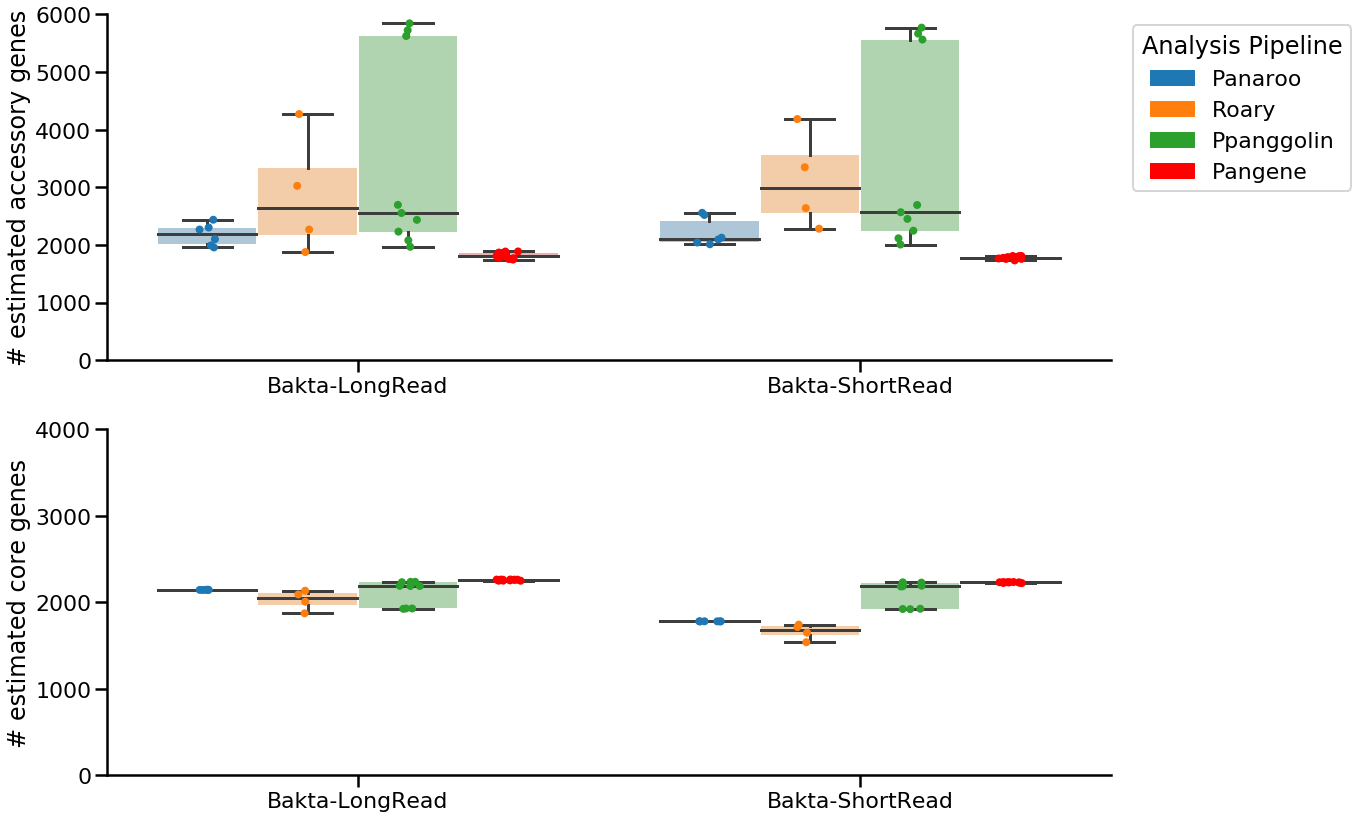

In [75]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
            hue_order = hue_Order_Tools,
            #order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
            hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 6000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

# Viz results coloring by Anno-AsmType combinations

In [83]:
AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                               #"PGAP-LongRead": "#2ca02c",
                               "Bakta-ShortRead": "#ff7f0e", }
                               #"PGAP-ShortRead": "#9467bd" }

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"],
                                     label='Bakta & Complete Assemblies (N=68)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"],
                                   label='Bakta & Short-Read Assemblies (N=68)')

AnnoAndTech_Patches = [Bakta_CompAsm_patch, Bakta_SRAsm_patch]

hue_orderToPlot_V2 = ["Bakta-LongRead",  "Bakta-ShortRead", ]

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()


In [77]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

In [78]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

In [79]:
pallete_ForPlot

dict_values(['#1f77b4', '#ff7f0e'])

In [80]:
#PGCombos_orderToPlot

In [81]:
AnnoAndTech_hue_Color_Dict

{'Bakta-LongRead': '#1f77b4', 'Bakta-ShortRead': '#ff7f0e'}

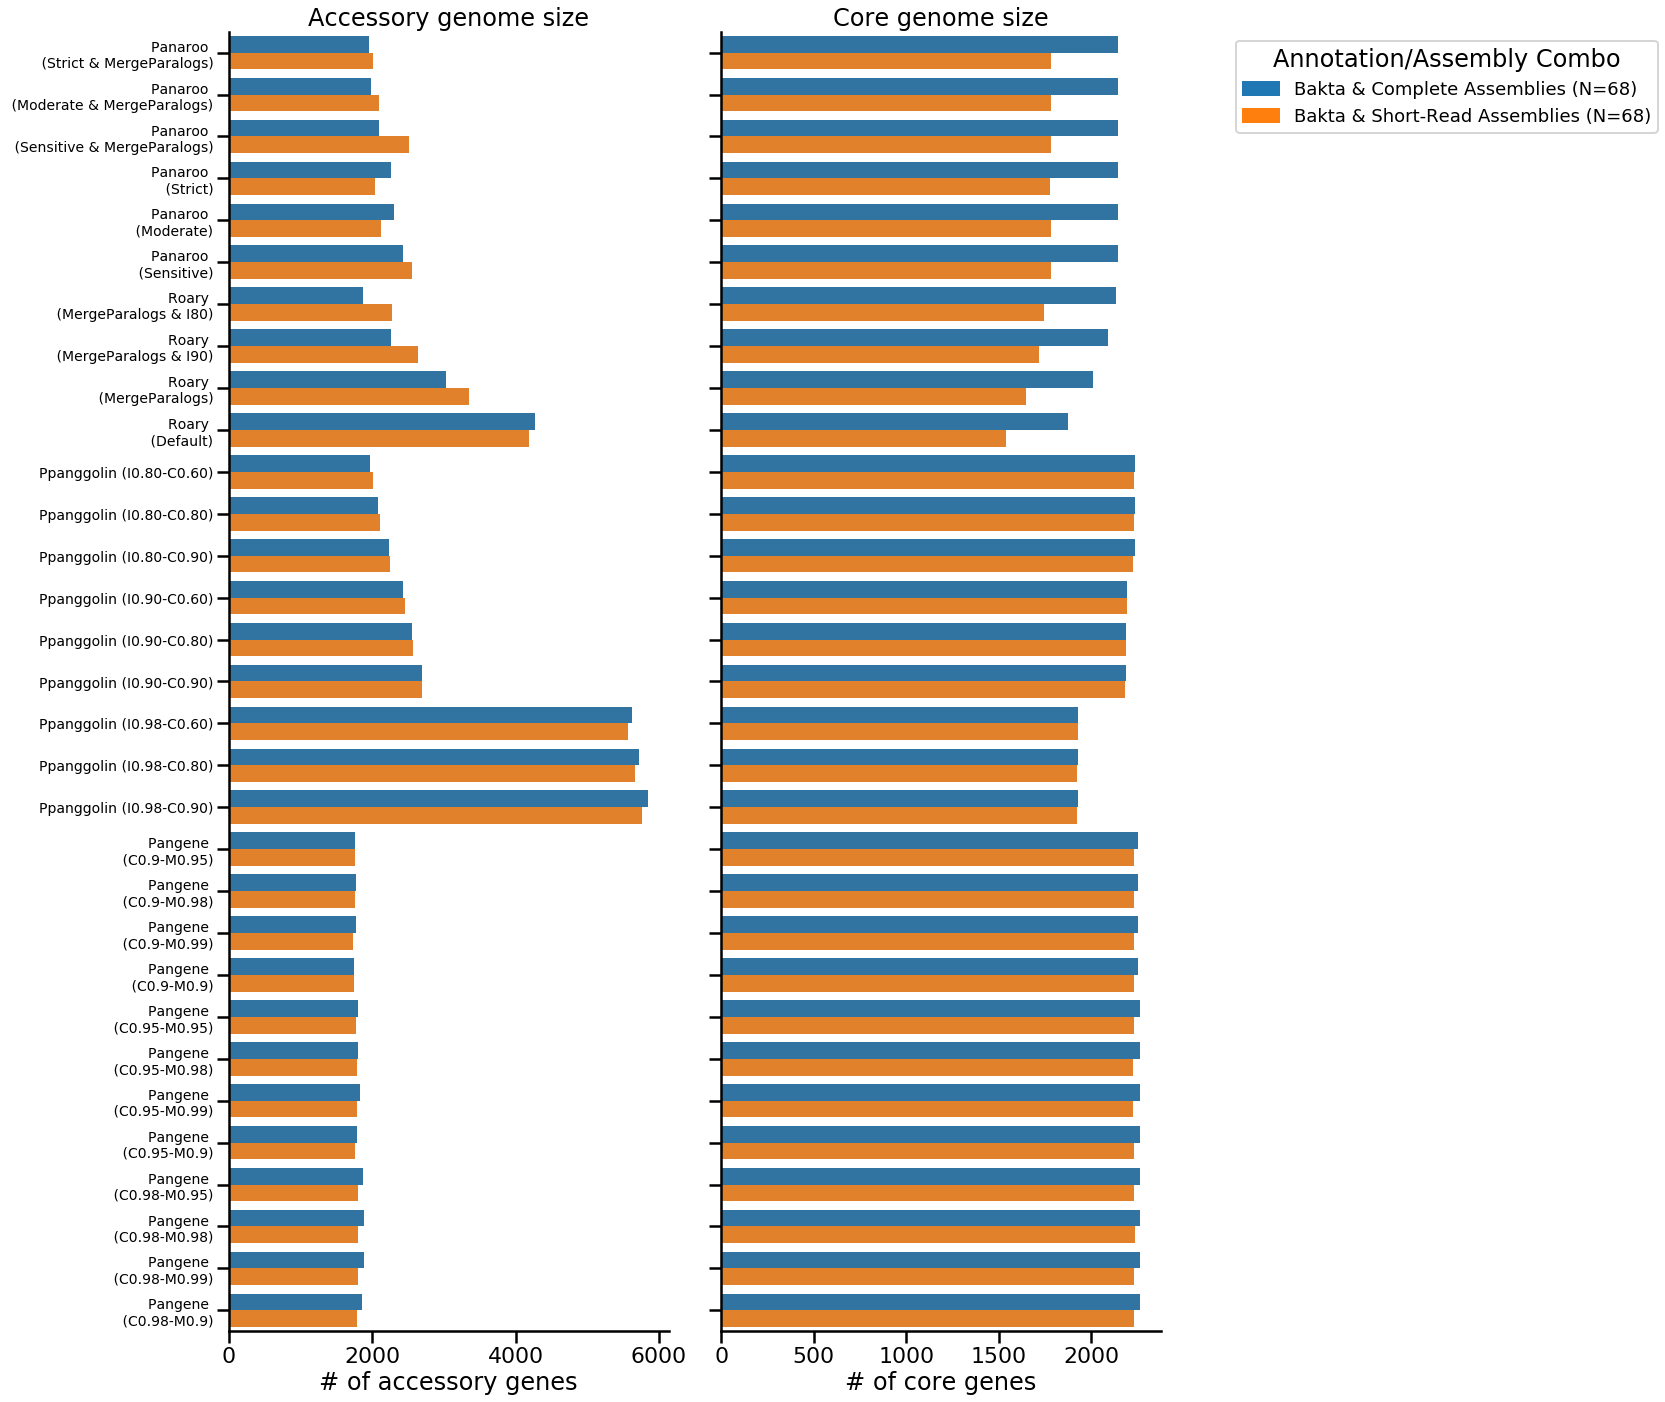

In [84]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
              bbox_to_anchor=(1.15, 1), fontsize= 18) 
axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.svg", bbox_inches="tight")

plt.show()